<h1 style="text-align: center;"> FINAL PROJECT </h1>
<h2 style="text-align: center;"> Dự đoán điểm IT001 từ dữ liệu làm bài trên WECODE </h2>

---

#### Lớp: CS114.P21

#### Thành viên nhóm

1. Nguyễn Chí Cường - 23520199
2. Hứa Mạnh Tân - 23521396
3. Nguyễn Tấn Tài - 23521376

#### MỤC LỤC

---

## 1. Chuẩn bị dữ liệu và một số thông tin về bộ dữ liệu

### 1.1. Import thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

### 1.2. Load bộ dữ liệu

In [2]:
# Đường dẫn đến các tập dữ liệu
WECODE_DATASET = "../dataset/wecode/annonimized.csv"
QT_DATASET = "../dataset/wecode/qt-public.csv"
TH_DATASET = "../dataset/wecode/th-public.csv"
CK_DATASET = "../dataset/wecode/ck-public.csv"

In [3]:
wecode_df = pd.read_csv(WECODE_DATASET).rename(
    columns={
        "concat('it001',`assignment_id`)": "assignment_id",
        "concat('it001',`problem_id`)": "problem_id",
        "concat('it001', username)": "username",
        "concat('it001',`language_id`)": "language_id",
    }
)

qt_df = pd.read_csv(QT_DATASET).rename(columns={"hash": "username", "diemqt": "QT"})
th_df = pd.read_csv(TH_DATASET).rename(columns={"hash": "username"})
ck_df = pd.read_csv(CK_DATASET).rename(columns={"hash": "username"})

### 1.3. Thông tin bộ dữ liệu

#### 1.3.1. Thông tin bộ dữ liệu làm bài tập Wecode của sinh viên

In [4]:
wecode_df.head(10)

,assignment_id,problem_id,username,is_final,status,pre_score,coefficient,language_id,created_at,updated_at,judgement
0,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:02:04,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
1,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,SCORE,0,100,it0012,10-09 08:04:41,10-09 08:04:51,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
2,90ce27571176d87961b565d5ef4b3de33ede04ac,789454427dd4097a14749e3dde63346b7a8d3811,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:06:49,10-09 08:06:58,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
3,90ce27571176d87961b565d5ef4b3de33ede04ac,bf96fbdc5f499538c3e2bfbec5779c8a14b0a9ff,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 08:47:52,10-09 08:48:01,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
4,90ce27571176d87961b565d5ef4b3de33ede04ac,7a6e5ca470ff47c3b5048f240c4738de71010c78,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:19:35,10-09 09:19:45,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
5,90ce27571176d87961b565d5ef4b3de33ede04ac,d6a5bdd7f7f32364f4743854ef3b5369c0706677,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,Compilation Error,0,100,it0012,10-09 09:29:03,10-09 09:30:08,"{""times"":[],""mems"":[],""verdicts"":{""\n\nIn func..."
6,90ce27571176d87961b565d5ef4b3de33ede04ac,d6a5bdd7f7f32364f4743854ef3b5369c0706677,ed9eaeb6a707f50154024b24d7efcb874a9795dd,1,SCORE,10000,100,it0012,10-09 09:29:58,10-09 09:30:08,"{""times"":[0,0,0,0,0,0,0,0,0,0],""mems"":[0,0,0,0..."
7,90ce27571176d87961b565d5ef4b3de33ede04ac,8b15ab090e1e8ec3284cf78746d94ffa00bd201b,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,Compilation Error,0,100,it0012,10-09 09:32:17,10-09 09:42:54,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd..."
8,90ce27571176d87961b565d5ef4b3de33ede04ac,8b15ab090e1e8ec3284cf78746d94ffa00bd201b,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,Compilation Error,0,100,it0012,10-09 09:33:36,10-09 09:33:36,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd..."
9,90ce27571176d87961b565d5ef4b3de33ede04ac,8b15ab090e1e8ec3284cf78746d94ffa00bd201b,ed9eaeb6a707f50154024b24d7efcb874a9795dd,0,Compilation Error,0,100,it0012,10-09 09:34:05,10-09 09:34:05,"{""times"":[],""mems"":[],""verdicts"":{""\n\nforbidd..."


In [5]:
wecode_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 295198 entries, 0 to 295197
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   assignment_id  295198 non-null  object
 1   problem_id     295198 non-null  object
 2   username       295198 non-null  object
 3   is_final       295198 non-null  int64 
 4   status         295198 non-null  object
 5   pre_score      295198 non-null  int64 
 6   coefficient    295198 non-null  int64 
 7   language_id    295198 non-null  object
 8   created_at     295198 non-null  object
 9   updated_at     295198 non-null  object
 10  judgement      295198 non-null  object
dtypes: int64(3), object(8)
memory usage: 24.8+ MB


In [6]:
wecode_df.nunique()

assignment_id       203
problem_id          469
username           1489
is_final              2
status                4
pre_score           631
coefficient           4
language_id           6
created_at       284530
updated_at       242976
judgement         58406
dtype: int64

Từ thông tin trên thì ta có thể nhận thấy ngay bộ dữ liệu không hề có cột nào bị bỏ trống (tất cả các cột đều có 295198 giá trị là non-null), nên ta không cần phải xử lí dữ liệu khuyết thiết cho dữ liệu này. 

Những ta dễ thấy, các đặc trưng của dữ liệu này không mang giá trị đánh giá chung về khả năng của sinh viên, mà nó chỉ chứa thông tin về những lần nộp bài wecode của sinh viên một các rời rạc, lẻ tẻ. Vì vậy, chúng cần phải được tổng hợp lại và thay thế bằng những đặc trưng mới có giá trị đánh giá hoạt động học tập của sinh viên (ví dụ: tổng điểm của các bài wecode, số lần thử nộp bài, số bài đã giải, ...). Và từ đó ta có thể xây dựng các mô hình dự đoán điểm quá trình, thực hành và cuối kì dựa trên các đặc trưng mới này hiệu quả hơn.

#### 1.3.2. Thông tin bộ dữ liệu điểm của sinh viên

In [7]:
qt_df.head(10)

,username,QT
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,7.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,7
2,01122b3ef7e59b84189e65985305f575d6bdf83c,9
3,013de369c439ab0ead8aa7da64423aa395a8be39,10
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,9
5,0155f91fe242fe55e1af631b0f0afbe9938b185c,9
6,016f87a7bd87f233a8633fba8a1ca7ef5c3c63c1,8
7,017ec1bbad0d598e5a86ac3bd595b870b6456e61,8
8,01ad03ec301749c033155fc17e657cc767d447c8,7
9,020ef1c31cb4751bbfa1a88fba782db3c402e2fa,9


In [8]:
qt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  761 non-null    object
 1   QT        755 non-null    object
dtypes: object(2)
memory usage: 12.0+ KB


In [9]:
qt_df.nunique()

username    761
QT           21
dtype: int64

In [10]:
th_df.head(10)

,username,TH
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,8.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,7
3,013de369c439ab0ead8aa7da64423aa395a8be39,10
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,6
5,0155f91fe242fe55e1af631b0f0afbe9938b185c,7.5
6,016f87a7bd87f233a8633fba8a1ca7ef5c3c63c1,8
7,017ec1bbad0d598e5a86ac3bd595b870b6456e61,8.5
8,01ad03ec301749c033155fc17e657cc767d447c8,7.5
9,020ef1c31cb4751bbfa1a88fba782db3c402e2fa,5.5


In [11]:
th_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  761 non-null    object
 1   TH        755 non-null    object
dtypes: object(2)
memory usage: 12.0+ KB


In [12]:
th_df.nunique()

username    761
TH           21
dtype: int64

In [13]:
ck_df.head(10)

,username,CK
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,5.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,6.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,4.5
3,013de369c439ab0ead8aa7da64423aa395a8be39,5.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,4.0
5,0155f91fe242fe55e1af631b0f0afbe9938b185c,4.0
6,016f87a7bd87f233a8633fba8a1ca7ef5c3c63c1,6.5
7,017ec1bbad0d598e5a86ac3bd595b870b6456e61,4.0
8,01ad03ec301749c033155fc17e657cc767d447c8,5.5
9,020ef1c31cb4751bbfa1a88fba782db3c402e2fa,5.0


In [14]:
ck_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   username  761 non-null    object 
 1   CK        755 non-null    float64
dtypes: float64(1), object(1)
memory usage: 12.0+ KB


In [15]:
ck_df.nunique()

username    761
CK           21
dtype: int64

Từ thông tin của 3 dataframe điểm trên, ta có thể thấy những thông tin sau:
- Cả 3 dataframe đều có 761 `username` non-null và khác nhau
- Cả 3 dataframe có cột điểm chỉ có 755/761 giá trị là non-null

In [16]:
print(
    "Number of similar usernames between qt_df and th_df: "
    + str(sum(qt_df["username"] == th_df["username"]))
)
print(
    "Number of similar usernames between qt_df and ck_df: "
    + str(sum(qt_df["username"] == ck_df["username"]))
)

Number of similar usernames between qt_df and th_df: 761
Number of similar usernames between qt_df and ck_df: 761


Nhận thấy cả 3 dataframe chứa điểm quá trình, thực hành, cuối kì của cùng 761 sinh viên, vậy nên ta có thể hợp nhất cả 3 dataframe được load riêng lẻ thành 1 dataframe duy nhất dể tiện hơn trong việc thao tác.

In [17]:
# Hợp nhất điểm từ 3 dataframe thành 1 dataframe score_df duy nhất
score_df = pd.merge(
    pd.merge(qt_df, th_df, on="username", how="inner"),
    ck_df,
    on="username",
    how="inner",
)
score_df["QT"] = pd.to_numeric(score_df["QT"], errors="coerce")
score_df["TH"] = pd.to_numeric(score_df["TH"], errors="coerce")
score_df["CK"] = pd.to_numeric(score_df["CK"], errors="coerce")

### 1.4. Xử lí dữ liệu khuyết thiếu

Đối với `wecode_df` thì hoàn toàn không hề có dữ liệu khuyết thiếu. Bây giờ, ta xem xét những hàng bị bỏ trống (NaN) trong `score_df` để thực hiện lọc hoặc lấp đầy chúng, tránh lỗi trong quá trình thao tác.

In [18]:
score_df[(score_df["QT"].isna()) | (score_df["TH"].isna()) | (score_df["CK"].isna())]

,username,QT,TH,CK
38,06024da8147b5cf6105beb4c403f67cf1ff0aea1,NaN,NaN,NaN
83,0d815307d5307124d148bbebfb41497230c4bd15,NaN,NaN,NaN
91,0eb93817d6eb3d5bd3e44dbc75971eea193b924f,NaN,NaN,NaN
195,209d7c77e7a150b6990a3372f7cb24da0c0e7e07,NaN,NaN,NaN
210,2383a9a33025aa8759fee9a890f6420df0fc8b47,NaN,NaN,NaN
244,2855b4b4d03c37c94117e615a25e0e321ec8d77a,NaN,NaN,NaN
515,59b2a9ae92876d8ce54309fe82bb92d7cffbc794,0.0,NaN,0.0
655,7186e8a3fb8c0322eee7e354ed8f1669885f6774,NaN,NaN,0.0


Ta dễ dàng nhận thấy rằng chỉ có 6 `username` có ít nhất 1 trong 3 cột bị bỏ trống (NaN), và thực chất là cả 3 cột đều bị bỏ trống. Vì vậy ta có thể loại những `username` này ra khỏi dataframe `score_df`.

In [19]:
# Xử lý lọc dữ liệu không hợp lệ
score_df = score_df.dropna()

Sau khi loại bỏ NaN thì kết quả dataframe `score_df` thu được chứa 755 dòng đều non-null:

In [20]:
score_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 753 entries, 0 to 760
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   username  753 non-null    object 
 1   QT        753 non-null    float64
 2   TH        753 non-null    float64
 3   CK        753 non-null    float64
dtypes: float64(3), object(1)
memory usage: 29.4+ KB


## 2. Trích xuất đặc trưng

Như đã phân tích ở phần 1 thì tập dữ liệu wecode hiện tại không thể được dùng trực tiếp để đánh giá năng lực học tập của sinh viên. Nó là một bản ghi log thông tin các lần nộp bài của sinh viên trên wecode. Do đó, cần phải tổng hợp các đặc trưng hiện tại và trích xuất ra thành các đặt trưng mới có giá trị đánh giá năng lực học tập của sinh viên hơn.

Từ tập dữ liệu wecode trên, một số đặc trưng mới có thể trích xuất từ các đặc trưng hiện tại có thể kể đến đó là:
- Tổng số lần nộp bài (`tries`)
- Tổng số lần thử đúng (`correct_tries`)
- Tổng số vấn đề đã thử giải (`tried_probs`)
- Tổng số vấn đề đã giải (`solved_probs`)
- Tổng điểm của tất cả các lần nộp (`total_score`)
- Tổng điểm cuối cùng (`total_final_score`)

In [21]:
wecode_df["real_score"] = wecode_df["pre_score"] * wecode_df["coefficient"] / 100

wecode_df["final_score"] = wecode_df["is_final"] * wecode_df["real_score"]

wecode_df["is_final_solution"] = wecode_df["is_final"] * (
    wecode_df["pre_score"] == 10000
)

extracted_wecode_df = (
    wecode_df.groupby("username")
    .agg(
        tries=("username", "size"),
        correct_tries=("pre_score", lambda x: sum(x == 10000)),
        tried_probs=("is_final", "sum"),
        solved_probs=("is_final_solution", "sum"),
        total_score=("real_score", "sum"),
        total_final_score=(
            "final_score",
            "sum",
        ),
    )
    .reset_index()
)

extracted_wecode_df.head(10)

,username,tries,correct_tries,tried_probs,solved_probs,total_score,total_final_score
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,54,46,46,809110.0,460000.0
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,85,78,72,1421535.0,752499.0
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,59,67,59,1164882.0,629214.0
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,100,52,47,47,595276.0,470000.0
4,013de369c439ab0ead8aa7da64423aa395a8be39,107,59,66,58,686802.0,602519.0
5,014c59c6433fd764a0b08de6ffeb757eaf60aa73,199,79,90,79,1042765.0,796000.0
6,0155f91fe242fe55e1af631b0f0afbe9938b185c,179,60,60,56,826531.0,562000.0
7,016f87a7bd87f233a8633fba8a1ca7ef5c3c63c1,364,75,77,68,1774884.0,712916.0
8,017ec1bbad0d598e5a86ac3bd595b870b6456e61,218,86,91,85,1380711.0,881142.0
9,01ad03ec301749c033155fc17e657cc767d447c8,271,76,74,68,1404394.0,698146.0


Thế nhưng, những đặc trưng đó chưa đủ để đánh giá năng lực của sinh viên, nên ta cần phải biến đổi thêm một lần nữa để thu về những đặc trưng có giá trị đánh giá tốt hơn:
- Trung bình số lần thử trên mỗi vấn đề (`tries/prob`)
- Tỉ lệ đúng của mỗi lần thử (`accuracy`)
- Trung bình điểm trên mỗi vấn đề (`score/prob`)
- Trung bình điểm trên mỗi lần thử (`score/try`)

In [22]:
extracted_wecode_df["tries/prob"] = (
    extracted_wecode_df["tries"] / extracted_wecode_df["tried_probs"]
)
extracted_wecode_df["accuracy"] = (
    extracted_wecode_df["correct_tries"] / extracted_wecode_df["tries"]
)
extracted_wecode_df["score/prob"] = (
    extracted_wecode_df["total_final_score"] / extracted_wecode_df["tried_probs"]
)
extracted_wecode_df["score/try"] = (
    extracted_wecode_df["total_score"] / extracted_wecode_df["tries"]
)
extracted_wecode_df.dropna(inplace=True)
extracted_wecode_df.head(10)

,username,tries,correct_tries,tried_probs,solved_probs,total_score,total_final_score,tries/prob,accuracy,score/prob,score/try
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,54,46,46,809110.0,460000.0,3.195652,0.367347,10000.000000,5504.149660
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,85,78,72,1421535.0,752499.0,3.320513,0.328185,9647.423077,5488.552124
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,59,67,59,1164882.0,629214.0,2.910448,0.302564,9391.253731,5973.753846
3,0134f9f410c65ad0e8c2254a7e9288670e02a183,100,52,47,47,595276.0,470000.0,2.127660,0.520000,10000.000000,5952.760000
4,013de369c439ab0ead8aa7da64423aa395a8be39,107,59,66,58,686802.0,602519.0,1.621212,0.551402,9129.075758,6418.710280
5,014c59c6433fd764a0b08de6ffeb757eaf60aa73,199,79,90,79,1042765.0,796000.0,2.211111,0.396985,8844.444444,5240.025126
6,0155f91fe242fe55e1af631b0f0afbe9938b185c,179,60,60,56,826531.0,562000.0,2.983333,0.335196,9366.666667,4617.491620
7,016f87a7bd87f233a8633fba8a1ca7ef5c3c63c1,364,75,77,68,1774884.0,712916.0,4.727273,0.206044,9258.649351,4876.054945
8,017ec1bbad0d598e5a86ac3bd595b870b6456e61,218,86,91,85,1380711.0,881142.0,2.395604,0.394495,9682.879121,6333.536697
9,01ad03ec301749c033155fc17e657cc767d447c8,271,76,74,68,1404394.0,698146.0,3.662162,0.280443,9434.405405,5182.265683


In [23]:
data_df = pd.merge(
    extracted_wecode_df,
    score_df,
    on="username",
    how="inner",
)
data_df.head(10)

,username,tries,correct_tries,tried_probs,solved_probs,total_score,total_final_score,tries/prob,accuracy,score/prob,score/try,QT,TH,CK
0,00b6dd4fc7eb817e03708c532016ef30ce564a61,147,54,46,46,809110.0,460000.0,3.195652,0.367347,10000.000000,5504.149660,7.5,5.0,5.5
1,00bef8afee8f3c595d535c9c03c490cac1a4f021,259,85,78,72,1421535.0,752499.0,3.320513,0.328185,9647.423077,5488.552124,7.0,8.5,6.5
2,01122b3ef7e59b84189e65985305f575d6bdf83c,195,59,67,59,1164882.0,629214.0,2.910448,0.302564,9391.253731,5973.753846,9.0,7.0,4.5
3,013de369c439ab0ead8aa7da64423aa395a8be39,107,59,66,58,686802.0,602519.0,1.621212,0.551402,9129.075758,6418.710280,10.0,10.0,5.0
4,014c59c6433fd764a0b08de6ffeb757eaf60aa73,199,79,90,79,1042765.0,796000.0,2.211111,0.396985,8844.444444,5240.025126,9.0,6.0,4.0
5,0155f91fe242fe55e1af631b0f0afbe9938b185c,179,60,60,56,826531.0,562000.0,2.983333,0.335196,9366.666667,4617.491620,9.0,7.5,4.0
6,016f87a7bd87f233a8633fba8a1ca7ef5c3c63c1,364,75,77,68,1774884.0,712916.0,4.727273,0.206044,9258.649351,4876.054945,8.0,8.0,6.5
7,017ec1bbad0d598e5a86ac3bd595b870b6456e61,218,86,91,85,1380711.0,881142.0,2.395604,0.394495,9682.879121,6333.536697,8.0,8.5,4.0
8,01ad03ec301749c033155fc17e657cc767d447c8,271,76,74,68,1404394.0,698146.0,3.662162,0.280443,9434.405405,5182.265683,7.0,7.5,5.5
9,020ef1c31cb4751bbfa1a88fba782db3c402e2fa,175,83,75,71,1175106.0,715000.0,2.333333,0.474286,9533.333333,6714.891429,9.0,5.5,5.0


In [24]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   username           753 non-null    object 
 1   tries              753 non-null    int64  
 2   correct_tries      753 non-null    int64  
 3   tried_probs        753 non-null    int64  
 4   solved_probs       753 non-null    int64  
 5   total_score        753 non-null    float64
 6   total_final_score  753 non-null    float64
 7   tries/prob         753 non-null    float64
 8   accuracy           753 non-null    float64
 9   score/prob         753 non-null    float64
 10  score/try          753 non-null    float64
 11  QT                 753 non-null    float64
 12  TH                 753 non-null    float64
 13  CK                 753 non-null    float64
dtypes: float64(9), int64(4), object(1)
memory usage: 82.5+ KB


## 3. Phân tích dữ liệu

### Tính toán correlation

Correlation matrix:
                         QT        TH        CK
tries              0.091657  0.331316  0.077368
correct_tries      0.123088  0.388121  0.061388
tried_probs        0.109005  0.358261  0.023079
solved_probs       0.121259  0.383047  0.044205
total_score        0.131059  0.415282  0.154005
total_final_score  0.116728  0.377536  0.039472
tries/prob        -0.020176  0.025893  0.014953
accuracy           0.058012 -0.018545 -0.044846
score/prob         0.086855  0.178366  0.001008
score/try          0.134888  0.176947  0.136702


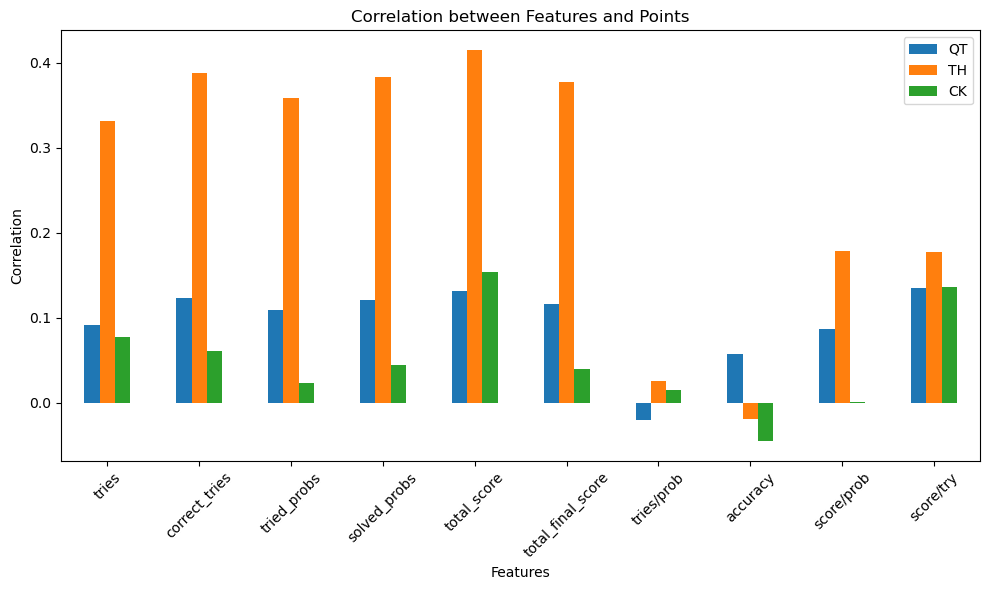

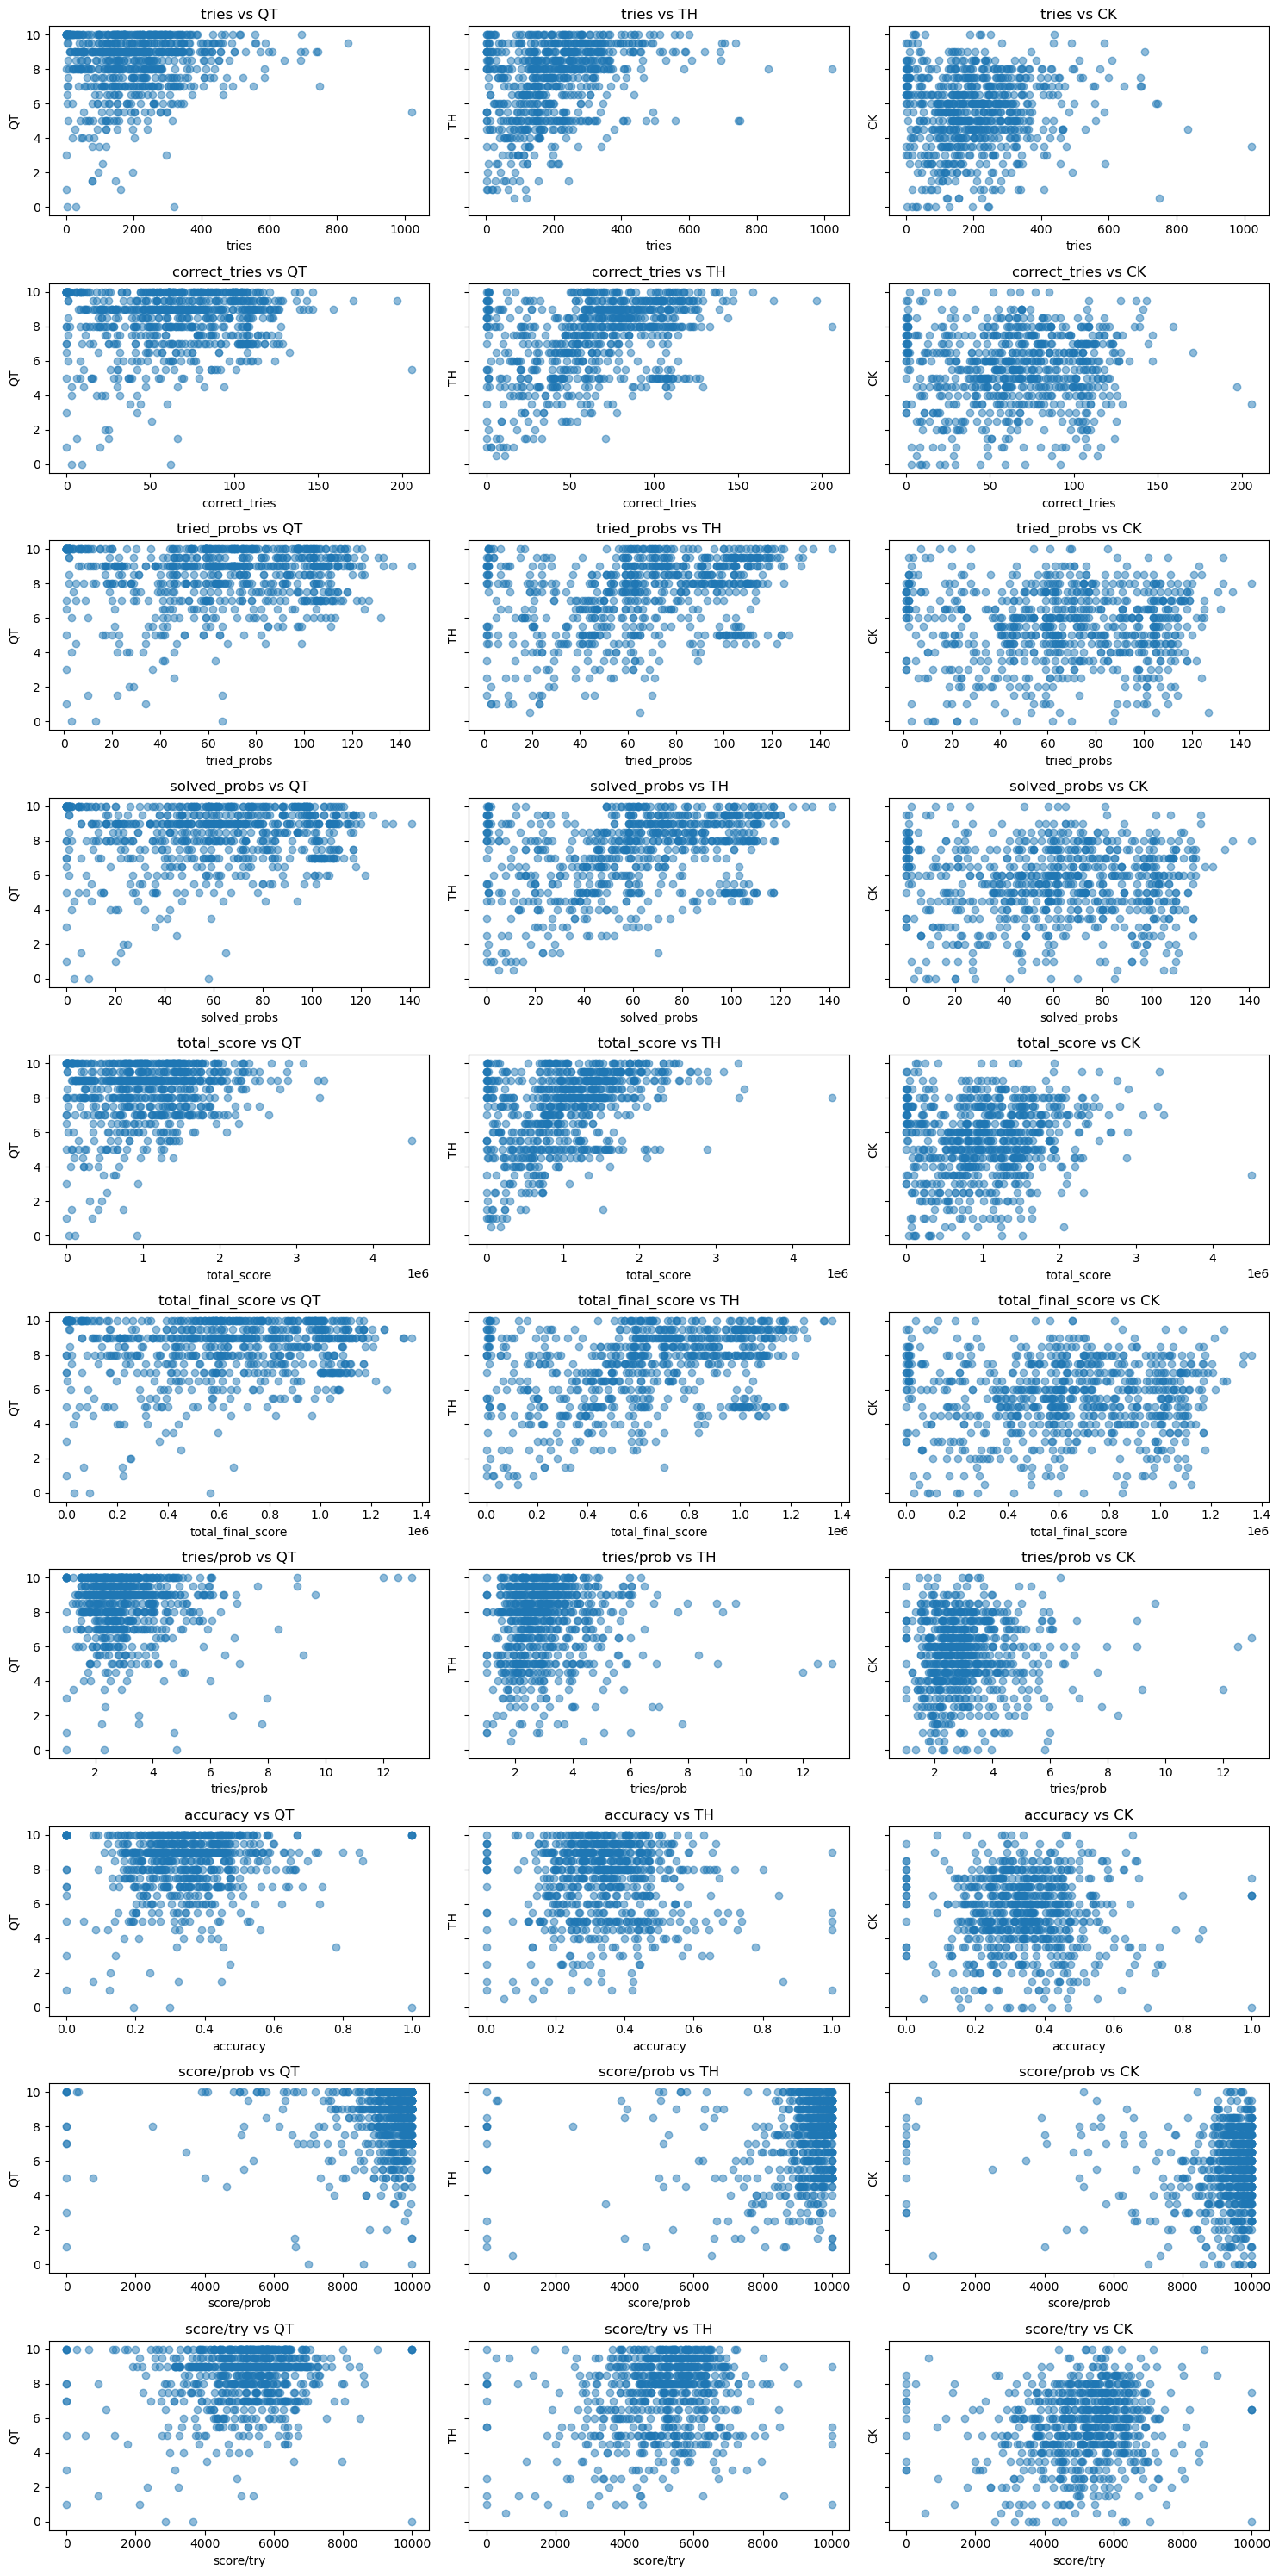

In [25]:
# Extract feature columns and point columns
feature_cols = data_df.columns[1:-3]  # All columns except the last 3
point_cols = data_df.columns[-3:]  # The last 3 columns

# Calculate correlation matrix
correlation_matrix = (
    data_df[feature_cols].corrwith(data_df[point_cols[0]]).to_frame(name=point_cols[0])
)
for point_col in point_cols[1:]:
    correlation_matrix[point_col] = data_df[feature_cols].corrwith(data_df[point_col])


print("Correlation matrix:")
print(correlation_matrix)

# Plot the correlation matrix
correlation_matrix.plot(
    kind="bar", figsize=(10, 6), title="Correlation between Features and Points"
)
plt.xlabel("Features")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot each feature column against each point column
fig, axes = plt.subplots(
    len(feature_cols), len(point_cols), figsize=(15, 30), sharey=True
)

for i, feature_col in enumerate(feature_cols):
    for j, point_col in enumerate(point_cols):
        axes[i, j].scatter(data_df[feature_col], data_df[point_col], alpha=0.5)
        axes[i, j].set_title(f"{feature_col} vs {point_col}")
        axes[i, j].set_xlabel(feature_col)
        axes[i, j].set_ylabel(point_col)

plt.tight_layout()
plt.show()

## 4. Huấn luyện mô hình dự đoán

### 4.2. Huấn luyện mô hình dự đoán điểm thực hành (TH)

In [ ]:
th_feature_cols = [
    "tries",
    "correct_tries",
    "tried_probs",
    "solved_probs",
    "total_score",
    "total_final_score",
]

X = data_df[feature_cols]
y = data_df["TH"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)


th_model = RandomForestRegressor(n_estimators=100, random_state=42)
th_model.fit(X_train, y_train)
y_pred = th_model.predict(X_test)

R^2 score for predicting TH: 0.11468385889445654


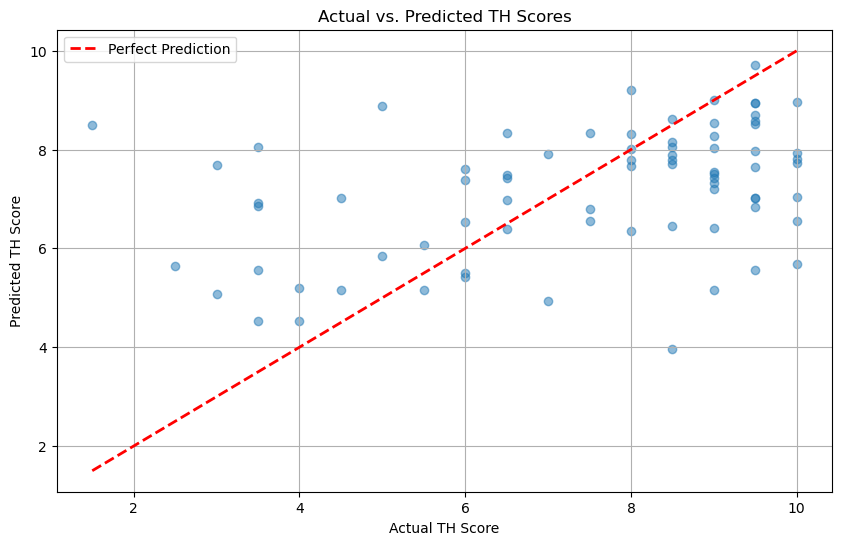

In [27]:
r2 = r2_score(y_test, y_pred)
print(f"R^2 score for predicting TH: {r2}")

# Plotting actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    "r--",
    lw=2,
    label="Perfect Prediction",
)
plt.title("Actual vs. Predicted TH Scores")
plt.xlabel("Actual TH Score")
plt.ylabel("Predicted TH Score")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X = extracted_wecode_df[feature_cols]
y_pred = th_model.predict(X)
y_pred = np.clip(y_pred, 0, 10)
predictions_df = pd.DataFrame(
    {"username": extracted_wecode_df["username"], "predicted_TH": y_pred}
)
predictions_df.to_csv("../th_predictions.csv", index=False)
print("Predictions saved to th_predictions.csv")

Predictions saved to th_predictions.csv
